## Predicting readmission of diabetic patients



**Table of contents**:
1. **Prepare Environment**:
2. **Exploratory Data Analysis**:
3. **Data preprocessing**:
4. **Model Fitting**:
5. **Model Evaluation**:
6. **Discussion**:
7. **References**:


**Caveat**: Modeling of health can be

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for patients with diabetes who receive various preventive and therapeutic interventions, many patients with diabetes do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals, as the patients are readmitted but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

Lets begin!

## Prepare Environment

In this section, we will (1) import the necessary Python packages to run this notebook, and (2) define some utilities to help downloading the data in an automatic fashion.

### Import dependencies

Instead of reinventing the wheel, we will leverage already existing Python packages. We will use `numpy` and `pandas` to easily deal and preprocess the data,  `matplotlib` and `seaborn` to create visualizations during our data analysis and result discussion, and finally, `sklearn` to implement a simple Machine Learning (ML) pipeline, i.e., we will fit a model and evaluate its quality.



In [1]:
# -----------------------------------------------------------
# Import data structures
# -----------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:.4f}".format)

# Import ML-related library
import sklearn as sk

# -----------------------------------------------------------
# Import visualization libraries
# -----------------------------------------------------------
# these will prove useful when analyzing the data but also
# when visualizing results
import matplotlib.pyplot as plt
import seaborn as sns
# add default configurations for the plots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="colorblind", rc=custom_params)

# Utils
from typing import Dict, List, Tuple

### Define auxiliar methods

We'd like to download the [Diabetes 130-US hospitals for years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) from the UCI Repository in order to run this notebook.

Let us define an auxiliary function to help us with downloading the data, we'll call it `download_diabetes_readmission_data`. This method expects no argument and it will return the tabular representation of the diabetes dataset available in the UCI repository. We represent this tabular data using a structure called `pandas.DataFrame`.




In [7]:
def load_diabetes_readmission_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Downloads the diabetes readmission data from the UCI repository."""
  import os, requests, zipfile
  # -----------------------------------------------------------
  # Obtain the data zip file and uncompress it
  # -----------------------------------------------------------
  url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"
  print(f"Downloading dataset from {url}...")
  r = requests.get(url, allow_redirects=True)

  filepath = "./content/diabetes_readmission.zip"
  print(f"Persisting zip file {filepath}...")
  with open(filepath, "wb") as f:
    f.write(r.content)

  with zipfile.ZipFile(filepath, "r") as zip_ref:
    zip_ref.extractall(f"../content")

  return pd.read_csv("diabetic_data.csv")

#### Plotting utils

In [8]:
def plot_pie(data: pd.DataFrame, col: str, colors=None, figsize=(4, 3), missing="?"):
    key_vals = sorted(data[col].value_counts().items(), key=lambda x: x[0] if x[0].lower() != missing else "zzzzz")
    keys, d = zip(*key_vals)
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"), dpi=150)
    if colors is None:
        palette_color = sns.color_palette("colorblind")
    else:
        palette_color = sns.color_palette(colors)

    # plotting data on chart
    wedges, texts, autotexts =  plt.pie(d, labels=keys, colors=palette_color, autopct='%.1f%%')
#    wedges, texts, autotexts =  plt.pie(d, colors=palette_color, autopct='%.1f%%')

    for autotext in autotexts:
        autotext.set_color("white")

    plt.setp(autotexts, size=7, weight="bold")
 #   ax.legend(wedges, keys,
  #        title="Patient's Age (binns)",
  #        loc="center left",
  #        bbox_to_anchor=(1, 0, 0.5, 1))



In [9]:
def plot_counts_barplot(data: pd.DataFrame, col: str, figsize=(8, 5), palette=None):
  col_counts = sorted(data[col].value_counts().items(), key=lambda x: x[0])
  vals, counts = zip(*col_counts)

  if palette is not None:
    palette = sns.color_palette(palette, n_colors=len(col_counts))

  plt.figure(figsize=figsize)
  plots = sns.barplot(x=np.array(vals), y=np.array(counts), palette=palette)

  for bar in plots.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    plots.annotate(
      format(bar.get_height() / len(data), '.2%'),
      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
      ha='center', va='center', size=10, xytext=(0, 8),
      textcoords='offset points',
    )
  plt.tight_layout()

## Exploratory Data Analysis (EDA)


Often overlooked, **Exploratory Data Analysis (EDA)** is one of the most important stages of the machine learning pipeline.
Using information gathered during this data analysis stage, we can inform decisions about not only which covariates and transformations to apply to the data but also about which machine learning algorithms to use.


In this section, we will (1) download the data, (2) obtain fundamental statistics about the data, (3) observe the covariates' distributions, and, finally, (4) assess whether there are any correlations we should take into account.

By the end of this section, you should be able to answer the following questions:

- How many records and covariates does the data have?
- How is the data organized? Is it represented in terms of unique patient identifiers or are there multiple records for the same patient?
- Does the distribution of the covariates make intuitive sense?
- Are there any correlations worth accounting for? Do they make intuitive sense?
- What is the distribution of the label? What is the distribution of the label across different socio-demographic groups?
- Is the data sample representative of the general population?

### Load data

In [11]:
data = load_diabetes_readmission_data()

Persisting zip file ./content/diabetes_readmission.zip...


EmptyDataError: No columns to parse from file

### Data basics

Let us first analyze how many rows and columns, we have access to.

In [ ]:
data.head(5)

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                 1  ...          No      No                   No   
1                 3  ...          No      Up                   No   
2                 2  ...          No      No                   No   
3                 2  ...          No      Up                   No   
4                 1  ...          No  Steady                   No   

   glipizide-metformin  glimepiride-pioglitazone  metformin-rosiglitazone  \
0                   No                        No                       No   
1                   No                        No                       No   
2                   No                        No                       No   
3                   No                        No                       No   
4                   No                        No                       No   

   metformin-pioglitazone  change diabetesMed readmitted  
0                      No      No          No         NO  
1                      No      Ch         Yes        >30  
2                      No      No         Yes         NO  
3                      No      Ch         Yes         NO  
4                      No      Ch         Yes         NO  

[5 rows x 50 columns]

In [ ]:
num_rows, num_cols = data.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

print()
print("Number of unique patients:", data["patient_nbr"].nunique())

Number of rows: 101766
Number of columns: 50

Number of unique patients: 71518


There are about 102k rows and 50 columns. Note, however, that from these 102k records, we have a **total of 71.5k unique patients**!


In fact, we're going to observe how many records do we have per patient. To this end, we will first compute for each patient, how many times it visited the hospital. Then, we will observe how many times do the patients visits the hospital.

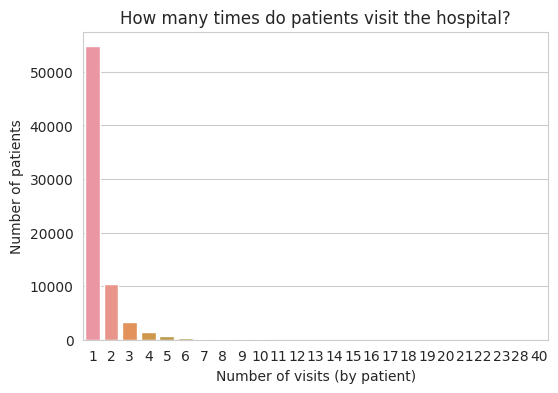

In [ ]:
# Obtain the number of total visits by patient
dist_visits_per_patient = data.groupby("patient_nbr").count()["encounter_id"]
# Compute proportion of times each patient visits the hospital X times
dist_visits_per_patient = dist_visits_per_patient.value_counts()
num_visits, counts = zip(*dist_visits_per_patient.items())
num_visits, counts = np.array(num_visits), np.array(counts)

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(x=num_visits, y=counts)
plt.xlabel("Number of visits (by patient)")
plt.ylabel("Number of patients")
plt.title("How many times do patients visit the hospital?")
plt.show()

To obtain a birds-eye view of the metadata of the diabetic patients readmission dataset, we can use the method `data.info()`. This will provide us information regarding the name of the columns, their type (e.g., numerical, ordinal, or categorical), and also about the missing values for each column.

**Column Names**: To better leverage this information, you may have to cross-reference the name of the columns with the metadata available in the [UCI Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) data.

**Column types**: In general, the numerical features will be listed as `float64`, the ordinal features as `int64`, and the categorical features as `objects`.

**Missing values**: Sometimes, it is the case that some columns have missing values. This could be caused by failures of the system and/or for example due to domain constraints, like only conducting specific exams or analysis in case of suspicious diseases.

---

As you proceed with the data analysis, you should ponder whether it makes sense for these columns to be included in the predictive model, if they are irrelevant to the problem (e.g., too noisy, high percentage of missing values), or if they are leaking information about the predictive task.




In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

We can observe a few things:

1. At a first glance, there seems to be no missing data (all columns exhibit a `Non-Null Count` of `101766`, which is the same name of the total rows of our data). This does not match with metadata in UCI repo, so there's a chance that the missing data was encoded somehow.
2. We have categorical, numerical, and ordinal covariates.



### Demographics

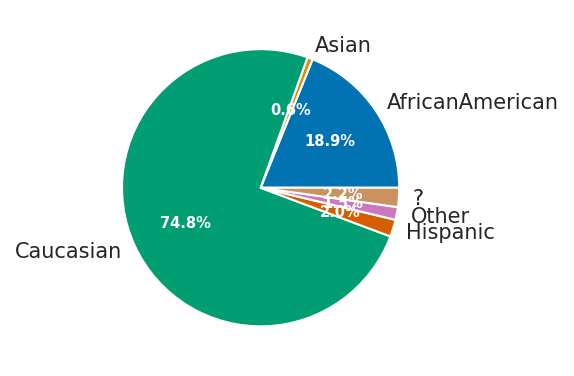

In [ ]:
plot_pie(data, "race")
# plot_pie(data.groupby("patient_nbr").head(1), "race")

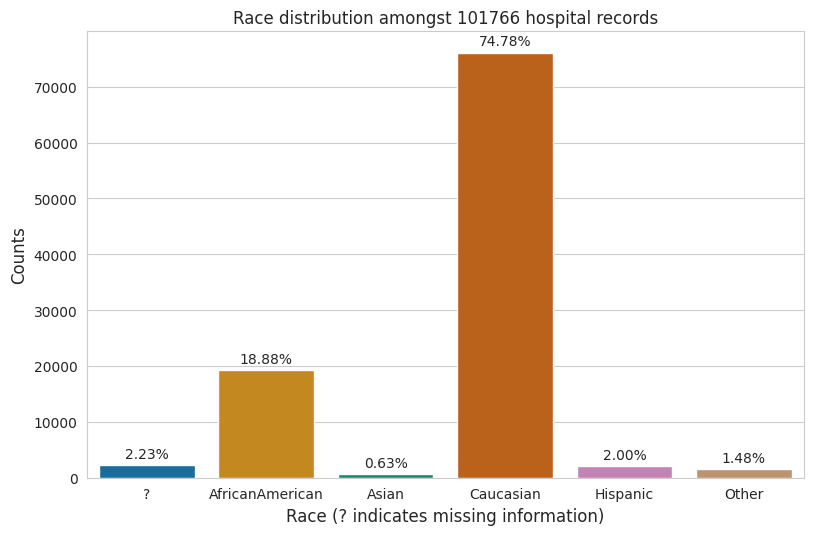

In [ ]:
plot_counts_barplot(data, "race")
# Setting the label for x-axis
plt.xlabel("Race (? indicates missing information)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Race distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

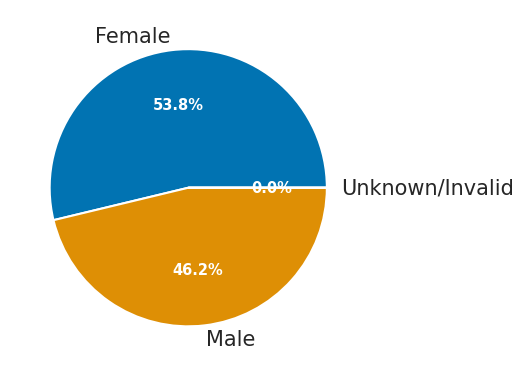

In [ ]:
plot_pie(data, "gender")

In [ ]:
data["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

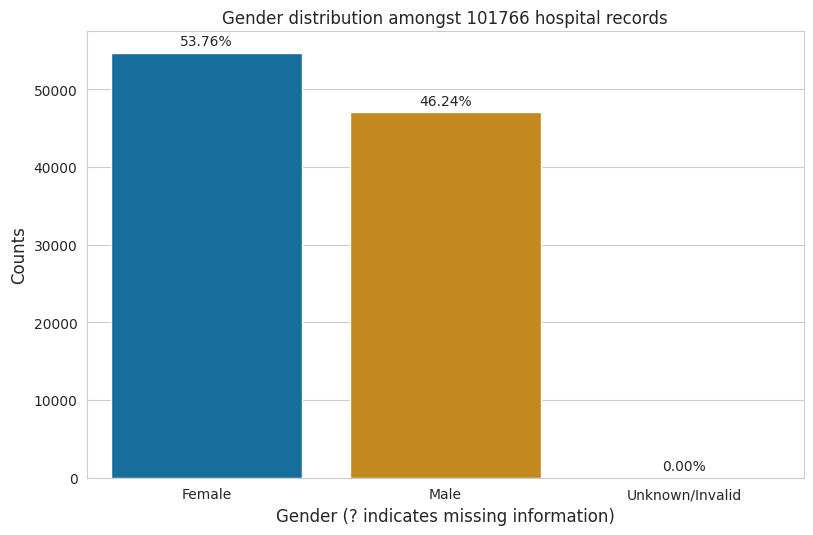

In [ ]:
plot_counts_barplot(data, "gender")
# Setting the label for x-axis
plt.xlabel("Gender (? indicates missing information)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Gender distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64

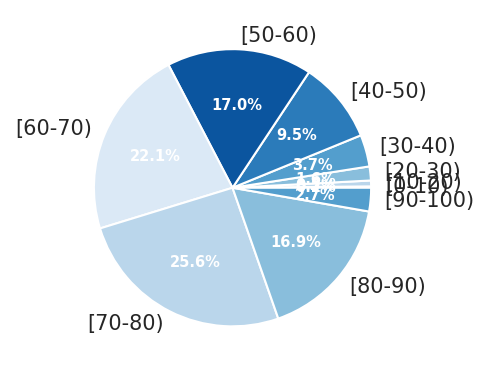

In [ ]:
plot_pie(data, "age", "Blues")
data.sort_values("age")["age"].value_counts() / len(data)

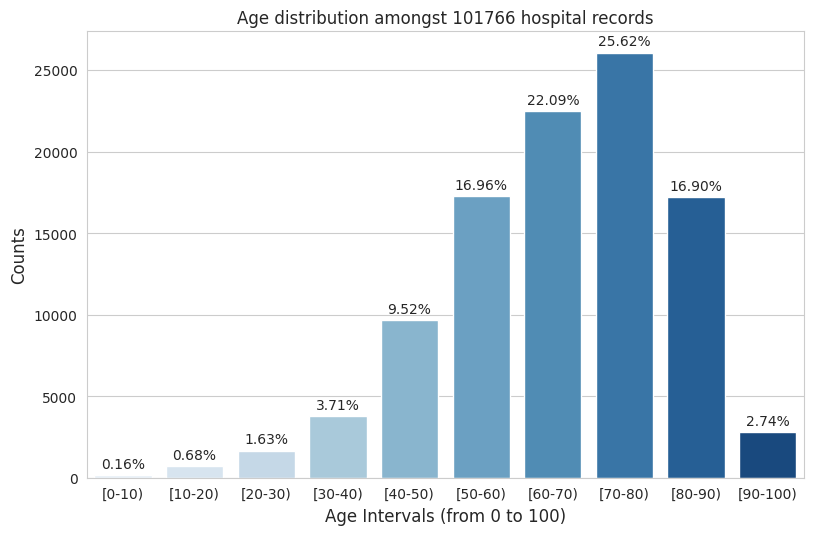

In [ ]:
plot_counts_barplot(data, "age", palette="Blues")
# Setting the label for x-axis
plt.xlabel("Age Intervals (from 0 to 100)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Age distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

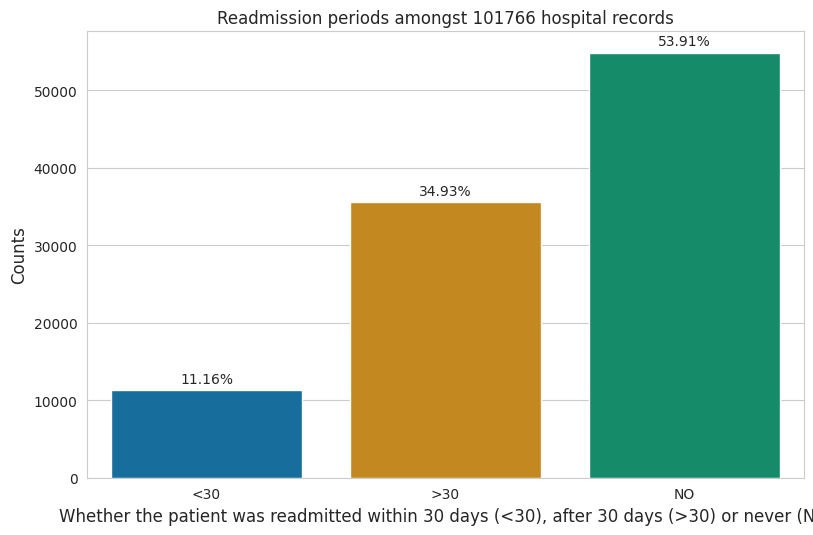

In [ ]:
plot_counts_barplot(data, "readmitted")

# Setting the label for x-axis
plt.xlabel("Whether the patient was readmitted within 30 days (<30), after 30 days (>30) or never (No)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Readmission periods amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

In [ ]:
1

In [ ]:
data_unique_patients["race"].

0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101754          Caucasian
101755              Other
101756              Other
101758          Caucasian
101765          Caucasian
Name: race, Length: 71518, dtype: object

## Data Preprocessing

create a relatively simple Python script (or jupyter notebook)  that can
1. download the data (its ok if you download a “local” version rather than from the original source),
2. does some very simple summarization of data properties (e.g., number of variables, number of patients, distribution of y-variable),
3. generates a simple histogram/density plot for 1 or 2 single variables and then a scatter plot of some 2 variables of interest (the seaborn library is quite nice),
4. and then fits a simple ML model (e.g., using scikit-learn) and evaluates it (accuracy, AUC, etc) on a test set.

This should be very simple and clearly explained - in the manner you would do if you **were teaching someone concepts in machine learning** for the first time. It would probably be a good idea to share these scripts with each other; they don’t need to be super-similar, but it would probably be good if they share similar plotting styles, etc.

In [118]:
# For package installations

!pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.8/150.0 MB 32.0 MB/s eta 0:00:05
   --- ------------------------------------ 11.3/150.0 MB 29.4 MB/s eta 0:00:05
   ---- ----------------------------------- 18.4/150.0 MB 31.3 MB/s eta 0:00:05
   ------ --------------------------------- 25.4/150.0 MB 31.6 MB/s eta 0:00:04
   -------- ------------------------------- 32.5/150.0 MB 32.2 MB/s eta 0:00:04
   --------- ------------------------------ 36.4/150.0 MB 30.9 MB/s eta 0:00:04
   ----------- ---------------------------- 44.3/150.0 MB 31.0 MB/s eta 0:00:04
   ------------- -------------------------- 52.4/150.0 MB 32.1 MB/s eta 0:00:04
   ---------------- ----------------------- 60.0/150.0 MB 32.7 MB/s eta 0:00:03
   ----------------- ---------------------- 66.6/150.0 MB 32.4 MB/s eta 0:00:03
   ------------------- -------------------- 73.7/150.0 MB 32.4 MB/s eta 0:00:03
   --------------------- ------------------ 80.5/1

In [2]:
# Task: Predict hospital readmission for diabetic inpatients. (multi-class classification)

import numpy as np # for data organization
import pandas as pd # for data organization

import sklearn as sk # for machine learning
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score # For Evaluation
from sklearn.model_selection import GridSearchCV # For Hyper Parameter Tuning
from sklearn.tree import DecisionTreeClassifier # For Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # For Random Forest Classifier
from xgboost import XGBClassifier # For XGBoost Classifier

import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
import zipfile as zf # for unzipping

In [3]:
# Code to extract dataset from zip

files = zf.ZipFile('diabetes_readmission.zip', 'r')
files.extractall('dataset')
files.close()

In [4]:
# Turn diabetes data csv into pandas dataframe

general_data = pd.read_csv('./dataset/diabetic_data.csv')

general_data

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

In [5]:
# General data properties

rows, cols = general_data.shape
num_unique_patients = general_data['patient_nbr'].nunique()
column_names = general_data.columns.tolist()

print("Number of rows: ", rows)
print("Number of columns: ", cols)
print("Number of unique patients: ", num_unique_patients)
print()
print("All Columns: ", column_names)

Number of rows:  101766
Number of columns:  50
Number of unique patients:  71518

All Columns:  ['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'time_in_hospital', 'payer_code', 'medical_specialty', 'num_lab_procedures', 'num_procedures', 'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton', 'insulin', 'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted']


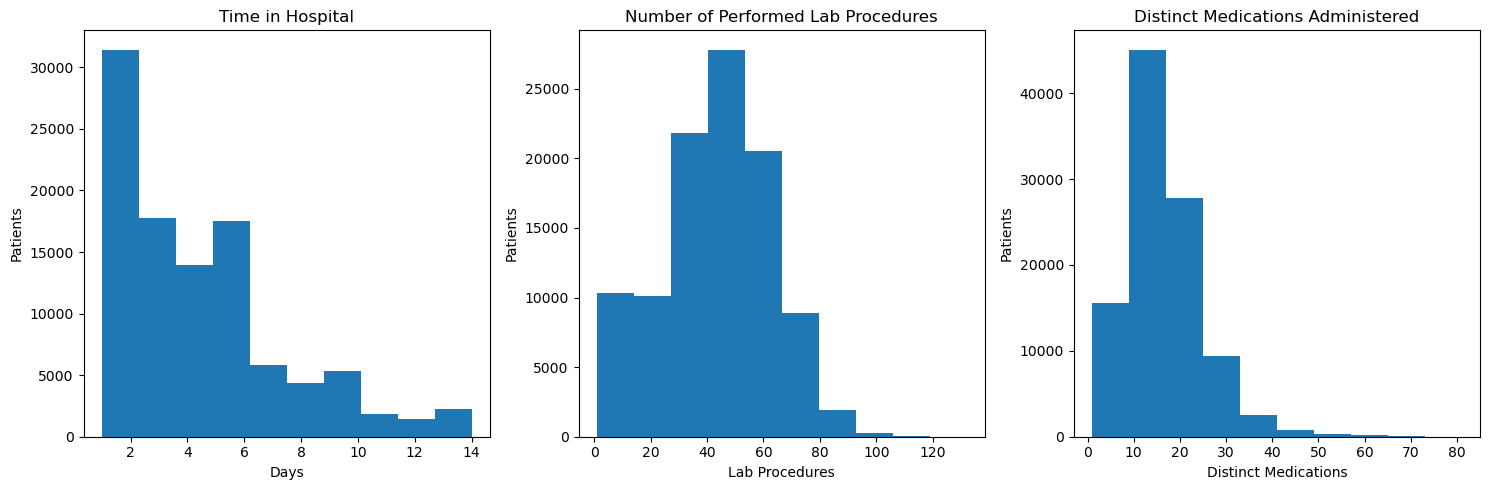

In [6]:
# Histograms showcasing certain columns
fig, ax = plt.subplots(1, 3, figsize=(15,5))
plt.subplots_adjust(wspace=0.3)
hist_columns = ['time_in_hospital', 'num_lab_procedures', 'num_procedures']

ax[0].hist(general_data['time_in_hospital'])
ax[0].set_title('Time in Hospital')
ax[0].set_xlabel('Days')
ax[0].set_ylabel('Patients')

ax[1].hist(general_data['num_lab_procedures'])
ax[1].set_title('Number of Performed Lab Procedures')
ax[1].set_xlabel('Lab Procedures')
ax[1].set_ylabel('Patients')

ax[2].hist(general_data['num_medications'])
ax[2].set_title('Distinct Medications Administered')
ax[2].set_xlabel('Distinct Medications')
ax[2].set_ylabel('Patients')

plt.tight_layout()

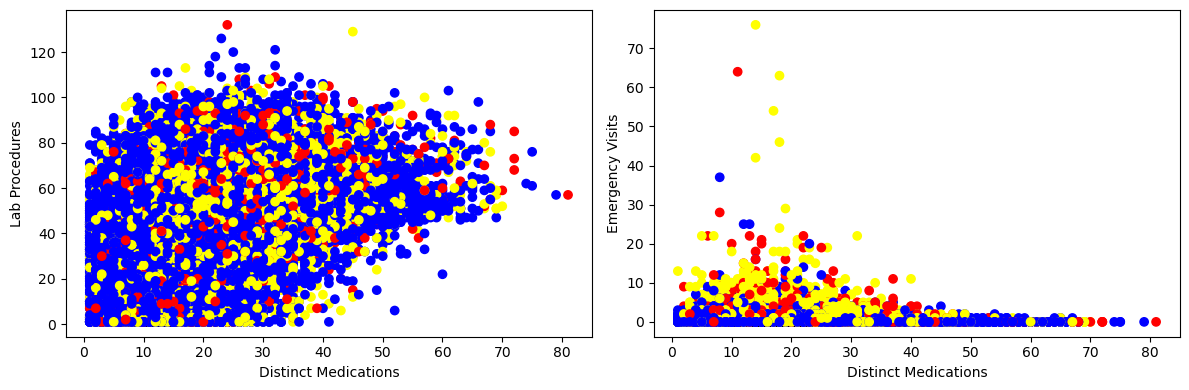

In [7]:
# Scatterplots showing the relations between certain columns

fig2, ax2 = plt.subplots(1, 2, figsize=(12, 4))

readmitted_to_color = {'NO': 'blue', '<30': 'red', '>30': 'yellow'} 
# Blue dots = no readmission, Red dots = less than 30 days readmission, Yellow dots = greater than 30 days readmission

scatter_color = general_data['readmitted'].map(readmitted_to_color)

ax2[0].scatter(general_data['num_medications'], general_data['num_lab_procedures'], c=scatter_color)
ax2[0].set_xlabel('Distinct Medications')
ax2[0].set_ylabel('Lab Procedures')

ax2[1].scatter(general_data['num_medications'], general_data['number_emergency'], c=scatter_color)
ax2[1].set_xlabel('Distinct Medications')
ax2[1].set_ylabel('Emergency Visits')

plt.tight_layout()

In [36]:
# Data cleaning, label-encoding, and splitting

# Remove columns with majority missing values
clean_data = general_data.drop(['weight', 'payer_code', 'medical_specialty'], axis=1)

# Convert the diag columns into float values
clean_data['diag_1'] = pd.to_numeric(clean_data['diag_1'], errors='coerce')
clean_data['diag_1'] = clean_data['diag_1'].fillna(clean_data['diag_1'].median())

clean_data['diag_2'] = pd.to_numeric(clean_data['diag_2'], errors='coerce')
clean_data['diag_2'] = clean_data['diag_2'].fillna(clean_data['diag_2'].median())

clean_data['diag_3'] = pd.to_numeric(clean_data['diag_3'], errors='coerce')
clean_data['diag_3'] = clean_data['diag_3'].fillna(clean_data['diag_3'].median())

# Label-encode the data
encoder = sk.preprocessing.LabelEncoder()
encoded_data = pd.DataFrame(clean_data)

for col_name, col_type in zip(clean_data.columns, clean_data.dtypes):
    if col_type != "int64" and col_type != "float64":
        encoded_data[col_name] = pd.DataFrame(encoder.fit_transform(encoded_data[col_name]))

# Split data into x and y 
x_encoded_data = encoded_data.drop('readmitted', axis=1)
y_encoded_data = encoded_data['readmitted']

x_tr, x_te, y_tr, y_te = sk.model_selection.train_test_split(x_encoded_data, y_encoded_data, test_size=0.2, shuffle=True)

print(x_tr.shape)
print(x_te.shape)
print(y_tr.shape)
print(y_te.shape)

(81412, 46)
(20354, 46)
(81412,)
(20354,)


## Model Fitting

In [25]:
# Random Forest Classifier (Default Hyper Parameters)
rf_model = RandomForestClassifier()
rf_model.fit(x_tr, y_tr)
rf_y_pred = rf_model.predict(x_te)

In [17]:
# Random Forest Classifier (Hyper Parameter Tuning)
rf_model_tuned = RandomForestClassifier()
rf_params = {"n_estimators": [50, 100, 300], 
             "max_depth": [3, 5, 7],
             "max_features": [2, 4, 6, 8],
             "min_samples_split": [2, 4, 6]}

rf_model_tuned = GridSearchCV(rf_model_tuned, rf_params, n_jobs = -1, cv = 5, verbose = 2)
rf_model_tuned.fit(x_tr, y_tr)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [23]:
rf_model_tuned.best_params_

{'max_depth': 7,
 'max_features': 8,
 'min_samples_split': 4,
 'n_estimators': 100}

In [26]:
rf_model_tuned = RandomForestClassifier(n_estimators = 100, max_depth = 7, min_samples_split = 4, max_features = 8)
rf_model_tuned.fit(x_tr, y_tr)
rf_tuned_y_pred = rf_model_tuned.predict(x_te)

In [27]:
# Decision Tree Classifier (Default Hyper Parameters)
dt_model = DecisionTreeClassifier()
dt_model.fit(x_tr, y_tr)
dt_y_pred = dt_model.predict(x_te)

In [28]:
# Decision Tree Classifier (Hyper Parameter Tuning)
dt_model_tuned = DecisionTreeClassifier()
dt_params = {"splitter": ["best", "random"], 
             "max_depth": [3, 5, 7], 
             "min_samples_split": [2, 4, 6], 
             "max_features": [2, 4, 6, 8]}

dt_model_tuned = GridSearchCV(dt_model_tuned, dt_params, n_jobs = -1, cv = 5, verbose = 3)
dt_model_tuned.fit(x_tr, y_tr)
dt_model_tuned.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


{'max_depth': 5, 'max_features': 8, 'min_samples_split': 2, 'splitter': 'best'}

In [28]:
dt_model_tuned = DecisionTreeClassifier(splitter = "best", max_depth = 5, max_features = 8, min_samples_split = 2)
dt_model_tuned.fit(x_tr, y_tr)
dt_tuned_y_pred = dt_model_tuned.predict(x_te)

In [29]:
# XGBoost Classifier (Default Hyper Parameters)
xgb_model = XGBClassifier()
xgb_model.fit(x_tr, y_tr)
xgb_y_pred = xgb_model.predict(x_te)

In [31]:
# XGBoost Classifier (Hyper Parameter Tuning)
xgb_model_tuned = XGBClassifier()
xgb_params = {"learning_rate": [0.05, 0.1, 0.2, 0.3],
              "max_depth": [3, 6, 9, 12],
              "subsample": [0.25, 0.5, 0.75, 1],
              "min_child_weight": [0, 0.5, 1, 2],
              "colsample_bytree": [0.25, 0.5, 0.75, 1]}

xgb_model_tuned = GridSearchCV(xgb_model_tuned, xgb_params, n_jobs = -1, cv = 5, verbose = 3)
xgb_model_tuned.fit(x_tr, y_tr)
xgb_model_tuned.best_params_

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 9,
 'min_child_weight': 0,
 'subsample': 1}

In [30]:
xgb_model_tuned = XGBClassifier(learning_rate = 0.1, colsample_bytree = 0.5, max_depth = 9, min_child_weight = 0, subsample = 1)
xgb_model_tuned.fit(x_tr, y_tr)
xgb_tuned_y_pred = xgb_model_tuned.predict(x_te)

## Model Evaluation

In [31]:
# Used to convert the the numerical y-data back into its represented y-labels
def convert_ynumeric_to_ylabel(data):
    new_data = data.astype("category")
    new_data = new_data.cat.rename_categories({0: "NO", 1: ">30", 2: "<30"})
    
    return new_data
    

In [32]:
# Used to produce confusion matrices and accuracy metrics for models
def confusion_matrix_and_metrics(y_te, y_pred):
    # Convert y values to y labels
    y_te = convert_ynumeric_to_ylabel(y_te)
    y_pred = convert_ynumeric_to_ylabel(pd.Series(y_pred))
    
    # Used to produce a pretty Confusion Matrix
    cm = confusion_matrix(y_te, y_pred, labels=["NO", ">30", "<30"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["NO", ">30", "<30"], yticklabels=["NO", ">30", "<30"])
    
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Used to produce metric data, precision, recall, F1 score, accuracy

    print("Precision of the MLP :\t" + str(precision_score(y_te, y_pred, average="macro")))
    print("Recall of the MLP    :\t" + str(recall_score(y_te, y_pred, average="macro")))
    print("F1 Score of the Model :\t" + str(f1_score(y_te, y_pred, average="macro")))
    print("Accuracy Score of the Model :\t" + str(round(accuracy_score(y_te, y_pred) * 100, 2)) + "%")

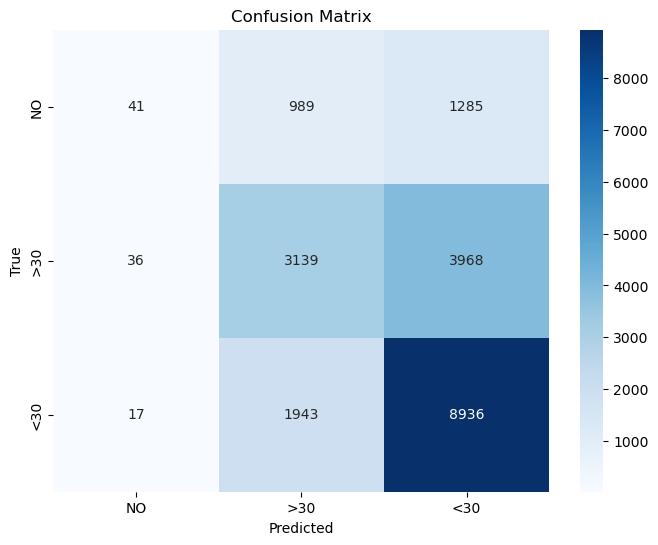

Precision of the MLP :	0.527667370068869
Recall of the MLP    :	0.42575975614387485
F1 Score of the Model :	0.4071996095739588
Accuracy Score of the Model :	59.53%


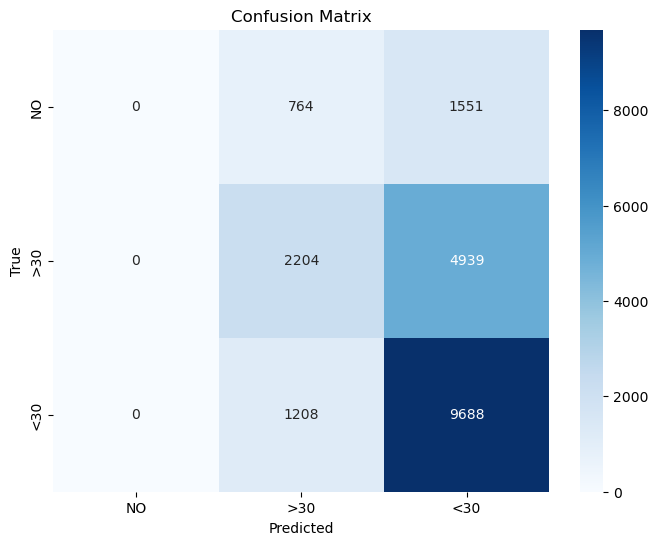

Precision of the MLP :	0.37553856860940554
Recall of the MLP    :	0.399229151980837
F1 Score of the Model :	0.3683672880929681
Accuracy Score of the Model :	58.43%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
# Evaluation of Random Forest Classifier
confusion_matrix_and_metrics(y_te, rf_y_pred) # Results of untuned Random Forest Classifier

confusion_matrix_and_metrics(y_te, rf_tuned_y_pred) # Results of tuned Random Forest Classifier

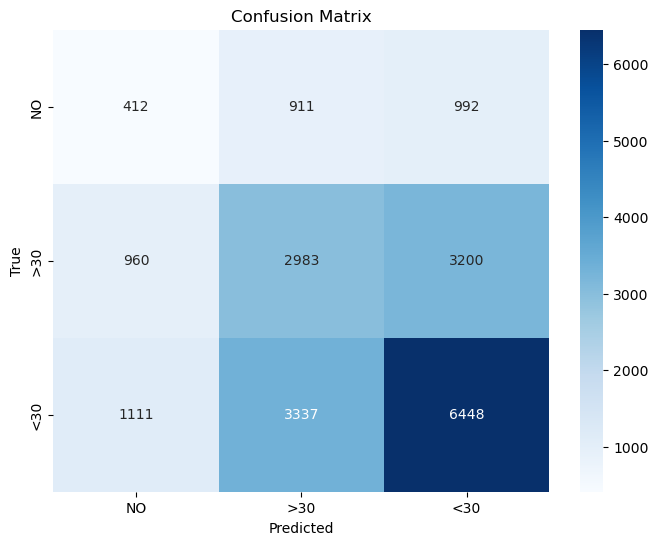

Precision of the MLP :	0.394824245826378
Recall of the MLP    :	0.39578606967043606
F1 Score of the Model :	0.395201492441448
Accuracy Score of the Model :	48.36%


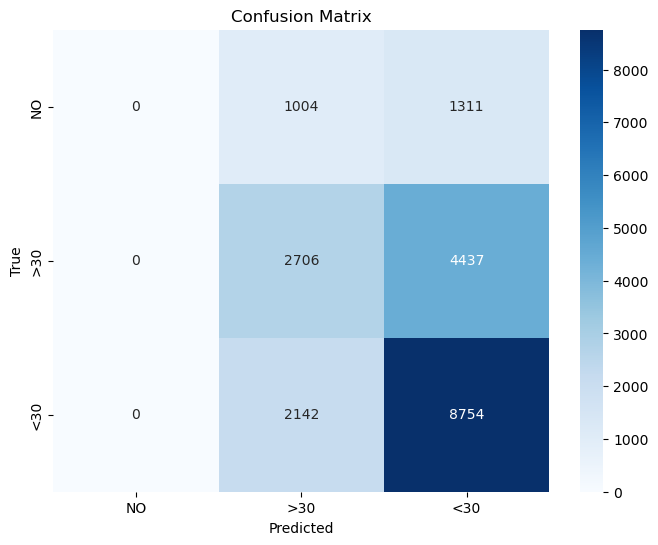

Precision of the MLP :	0.3553489640526637
Recall of the MLP    :	0.3940821734226108
F1 Score of the Model :	0.3686044966745798
Accuracy Score of the Model :	56.3%


C:\Users\HP\miniconda3\envs\cs189\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [34]:
# Evaluation of Decision Tree Classifier
confusion_matrix_and_metrics(y_te, dt_y_pred) # Results of untuned Decision Tree Classifier

confusion_matrix_and_metrics(y_te, dt_tuned_y_pred) # Results of tuned Decision Tree Classifier

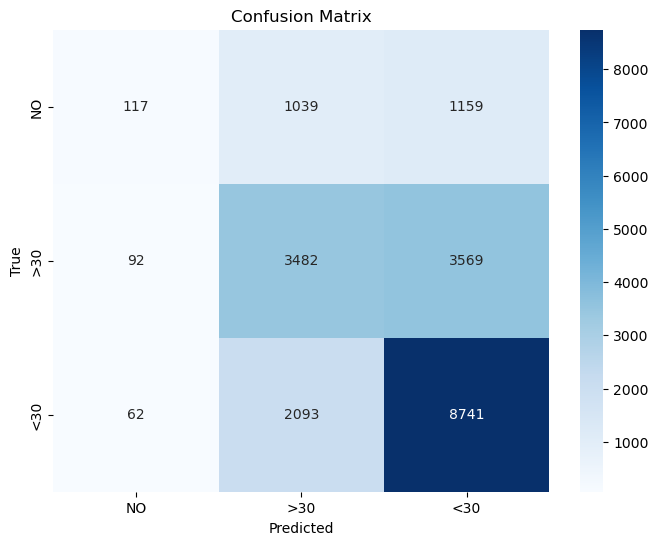

Precision of the MLP :	0.5357216854910137
Recall of the MLP    :	0.446743735310005
F1 Score of the Model :	0.43806895802237245
Accuracy Score of the Model :	60.63%


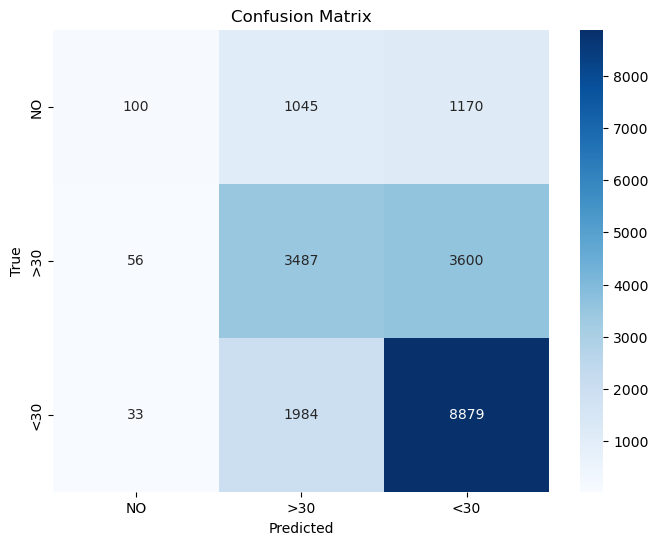

Precision of the MLP :	0.5715895457612853
Recall of the MLP    :	0.4487509925470609
F1 Score of the Model :	0.43797959393828273
Accuracy Score of the Model :	61.25%


In [35]:
# Evaluation of XGB Classifier
confusion_matrix_and_metrics(y_te, xgb_y_pred) # Results of untuned XGB Classifier

confusion_matrix_and_metrics(y_te, xgb_tuned_y_pred) # Results of tuned XGB Classifier

## Discussion

In [ ]:
# For this assignment I focused on practicing the general flow of processing data with machine learning. I started with visualizing the data with
# bar plots and scatter plots. I found the data to be balanced in many numerical columns such as with time spent in hospital and number of distinct
# medications. The scatter plots I found that certain columns had no correlation with each other while some others did, such as with my second scatter 
# plot. I then started the process of data processing in which I found that the many classifiers we could used required the conversion of the column
# data types into floats. Thus, the main task was converting the categorical columns into numerical types. I managed to do this through label-encoding,
# which simply took each category in each column and assigned it a unique number. I believe that there could be many downsides to this kind of encoding,
# which includes that the data can be seen in an ordered manner even though the categories have no apparent order which can mislead the models. Given
# more time I would've tried one hot encoding which avoids the ordering issue. I then split the data into an 80-20 split for training and test data. I
# tested Random Forest Classifier, Decision Tree Classifier, and XGB Classifier. Random Forest uses an ensemble of Decision Trees it produces 
# in parallel while XGB uses an ensemble of Decision Trees it produces sequentially. Decision Tree uses a simple single tree to make its decisions. I
# also used GridSearchCV to brute force find the best combination of hyper parameters for each model and produced a "tuned" version of each classifier.
# The concluding results showed that the Decision Tree was significantly worse then the other two classifiers with around a 48% accuracy. For
# Random Forest and XBG, both averaged around 60% with XGB having the slight edge with a 60% accuracy compared to Random Forest's 59% accuracy. For,
# the tuned versions, Decision Tree's tuned model performed significantly better with a 56% accuracy. This shows that hyper parameter tuning can be
# extremely beneficial for certain models. Random Forest's tuned version actually did worse with a 58% accuracy and XGB tuned version with a slight
# increase up to 61% accuracy. From these results, we know that Random Forest and XGB perform far better then Decision Tree which intuitively makes
# sense since the other two models employ model Decision Trees in their structure instead of just a single tree. I also noticed from these results, that
# a large part of model accuracy and prediction is dependent on the transformation of the data (feature engineering). Other examples have shown these 
# classifiers performing with a 90% accuracy, meaning the only logical difference is the better transformation of the data to support the model's
# learning. Given more time, I would heavily push my efforts towards transforming and scaling the features given in the data to achieve a higher
# accuracy in future model iterations.

## References

1. UCI ML Repo
2. Original dataset
3. Fairlearn tutorial

References

In [ ]:
https://gursev-pirge.medium.com/performance-comparison-of-multi-class-classification-algorithms-606e8ba4e0ee

In [ ]:
https://scikit-learn.org/stable/

In [ ]:
https://www.kaggle.com/datasets/brandao/diabetes